In [1]:
# Dependencies
import pandas as pd
from scipy.io import loadmat
import glob
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import LSTM,Dropout,Dense 
import keras.metrics
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F


## Step 1: Load the data.

- Complete the dataset class with the skeleton below.
- Add any transforms you feel are necessary.

Your class should have at least 3 elements
- An ```__init__``` function that sets up your class and all the necessary parameters.
- An ```__len__``` function that returns the size of your dataset.
- An ```__getitem__``` function that given an index within the limits of the size of the dataset returns the associated image and label in tensor form.

You may add more helper functions if you want.

In this section we are following the Pytorch [dataset](https://pytorch.org/vision/stable/datasets.html) class structure. You can take inspiration from their documentation.

In [41]:
# folder names
dc_folders = ['Europe', 'Japan', 'USA']

# Implement the dataset class
class DrivingCyclesDataset(Dataset):
    def __init__(self,
                 path_to_dc,
                 idxs_train,
                 idxs_test,
                 train=True):
        # path_to_dc: where you put the driving cycles dataset
        # idxs_train: training set indexes
        # idxs_test: test set indexes
        # train: return training set or test set
        
        # Load all the driving cycles
        alldata = []
        dcnames = []
        mat = loadmat('./DrivingCycles/WLTPextended.mat')
        df = pd.DataFrame(mat['V_z'], columns = ['V_z']) # velocity 
        df2 = pd.DataFrame(mat['T_z'], columns = ['T_z']) # time
        df3 = pd.DataFrame(mat['D_z'], columns = ['D_z']) # acceleration
        # df4 = pd.DataFrame(mat['G_z'], columns = ['G_z']) 
        df = pd.concat([df, df2, df3], axis=1)
        df['v_ave'] = df['V_z'].mean()
        df['v_max'] = df['V_z'].max()
        df['v_min'] = df['V_z'].min()
        df['a_ave'] = df['D_z'].mean()
        alldata.append(df)
        dcnames.append('WLTPextended.mat')
        for folder in dc_folders:
            image_path = os.path.join(path_to_dc, folder)
            files = glob.glob(image_path + '/*.mat')
            for f in files:
                mat = loadmat(f)
                df = pd.DataFrame(mat['V_z'], columns = ['V_z'])
                df2 = pd.DataFrame(mat['T_z'], columns = ['T_z'])
                df3 = pd.DataFrame(mat['D_z'], columns = ['D_z'])
                df = pd.concat([df, df2, df3], axis=1)
                df['v_ave'] = df['V_z'].mean()
                df['v_max'] = df['V_z'].max()
                df['v_min'] = df['V_z'].min()
                df['a_ave'] = df['D_z'].mean()
                dcnames.append(os.path.basename(f))
                # each dataframe is a driving cycle 
                alldata.append(df)

        # Extract the driving cycles with the specified file indexes     
        alldata_np = (np.array(alldata))[p] #numpy array of dataframes 
        dcnames_np = (np.array(dcnames))[p]
        if train==True:
            self.data = alldata_np[:idxs_train]
            self.names = dcnames_np[:idxs_train]
        else:
            self.data = alldata_np[idxs_test-1:]
            self.names = dcnames_np[idxs_test-1:]

    def __len__(self, idx):
        # Return the number of samples in a driving cycle 
        return (self.data[idx]).size
        
    def __getitem__(self, idx):
        # Get an item using its index
        # Return the driving cycle and its name 
        return self.data[idx]

In [46]:
def split_train_test(lendata, percentage=0.8):
    idxs_train = int(percentage * lendata)
    idxs_test = idxs_train + 1 
    return idxs_train, idxs_test

LENDATA = 36 + 6 + 4 + 1 # number of driving cycles = 47
np.random.seed(42)
idxs_train, idxs_test = split_train_test(LENDATA,0.8)
idxs_test = 47 # only 1 test driving cycle for easier visualisation
idxs_train = 46 
p = np.random.permutation(int(LENDATA))

In [47]:
def create_dataset(dataset):
    x = [] #append the last 50 values
    y = [] #append the future value 
    for df in dataset:
        for i in range(50, df.shape[0]):
            x.append(df.loc[i-50:i, "V_z"])
            y.append(df.loc[i, "V_z"])
        # for each driving cycle dataframe, have sets of 51 values 
        # 50 values are past values, 1 value is future value 
    x = np.array(x) 
    y = np.array(y)
    return x,y

## Step 2: Explore the data. (15 Points)

### Step 2.1: Data visualisation. (5 points)

- Plot data distribution, i.e. the number of samples per class.
- Plot 1 sample from each of the five classes in the training set.

/var/folders/cw/bwljv91s2pq0yk6ckv58m7f40000gn/T/ipykernel_50835/2294514957.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  alldata_np = (np.array(alldata))[p] #numpy array of dataframes
/var/folders/cw/bwljv91s2pq0yk6ckv58m7f40000gn/T/ipykernel_50835/2294514957.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  alldata_np = (np.array(alldata))[p] #numpy array of dataframes


               V_z          T_z           D_z         v_ave         v_max  \
count  1220.000000  1220.000000  1.220000e+03  1.220000e+03  1.220000e+03   
mean      8.960383   610.500000 -2.912060e-18  8.960383e+00  3.333333e+01   
std       8.636899   352.327972  4.223170e-01  1.777085e-15  7.108341e-15   
min       0.000000     1.000000 -1.388889e+00  8.960383e+00  3.333333e+01   
25%       0.000000   305.750000  0.000000e+00  8.960383e+00  3.333333e+01   
50%       8.888889   610.500000  0.000000e+00  8.960383e+00  3.333333e+01   
75%      13.888889   915.250000  0.000000e+00  8.960383e+00  3.333333e+01   
max      33.333333  1220.000000  1.041667e+00  8.960383e+00  3.333333e+01   

        v_min         a_ave  
count  1220.0  1.220000e+03  
mean      0.0 -2.912060e-18  
std       0.0  0.000000e+00  
min       0.0 -2.912060e-18  
25%       0.0 -2.912060e-18  
50%       0.0 -2.912060e-18  
75%       0.0 -2.912060e-18  
max       0.0 -2.912060e-18  


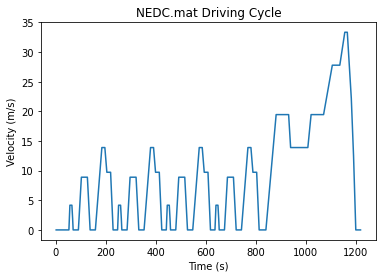

               V_z          T_z           D_z        v_ave         v_max  \
count  1801.000000  1801.000000  1.801000e+03  1801.000000  1.801000e+03   
mean     12.916374   900.000000 -1.972634e-18    12.916374  3.647222e+01   
std      10.010289   520.048235  5.316315e-01     0.000000  7.107401e-15   
min       0.000000     0.000000 -1.500000e+00    12.916374  3.647222e+01   
25%       4.916667   450.000000 -1.944444e-01    12.916374  3.647222e+01   
50%      11.527778   900.000000  0.000000e+00    12.916374  3.647222e+01   
75%      19.444444  1350.000000  2.222222e-01    12.916374  3.647222e+01   
max      36.472222  1800.000000  1.750000e+00    12.916374  3.647222e+01   

        v_min         a_ave  
count  1801.0  1.801000e+03  
mean      0.0 -1.972634e-18  
std       0.0  7.705859e-34  
min       0.0 -1.972634e-18  
25%       0.0 -1.972634e-18  
50%       0.0 -1.972634e-18  
75%       0.0 -1.972634e-18  
max       0.0 -1.972634e-18  


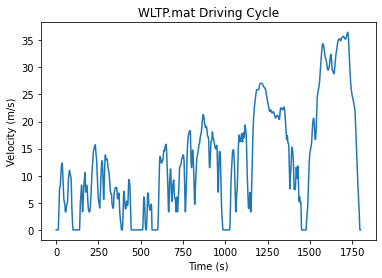

              V_z         T_z           D_z         v_ave       v_max  v_min  \
count  135.000000  135.000000  1.350000e+02  1.350000e+02  135.000000  135.0   
mean     4.917696   68.000000 -6.579099e-18  4.917696e+00   11.111111    0.0   
std      4.064388   39.115214  4.793549e-01  8.914864e-16    0.000000    0.0   
min      0.000000    1.000000 -7.936508e-01  4.917696e+00   11.111111    0.0   
25%      0.000000   34.500000 -2.777778e-01  4.917696e+00   11.111111    0.0   
50%      5.555556   68.000000  0.000000e+00  4.917696e+00   11.111111    0.0   
75%      8.333333  101.500000  2.222222e-05  4.917696e+00   11.111111    0.0   
max     11.111111  135.000000  7.936508e-01  4.917696e+00   11.111111    0.0   

              a_ave  
count  1.350000e+02  
mean  -6.579099e-18  
std    7.732412e-34  
min   -6.579099e-18  
25%   -6.579099e-18  
50%   -6.579099e-18  
75%   -6.579099e-18  
max   -6.579099e-18  


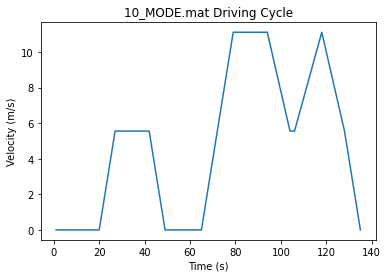

               V_z          T_z           D_z         v_ave         v_max  \
count  1877.000000  1877.000000  1.877000e+03  1.877000e+03  1.877000e+03   
mean      9.465903   939.000000 -9.463808e-19  9.465903e+00  2.533333e+01   
std       7.130921   541.987546  6.308829e-01  1.776830e-15  3.553660e-15   
min       0.000000     1.000000 -1.500000e+00  9.465903e+00  2.533333e+01   
25%       2.805556   470.000000 -1.666667e-01  9.465903e+00  2.533333e+01   
50%      10.055556   939.000000  0.000000e+00  9.465903e+00  2.533333e+01   
75%      13.333333  1408.000000  2.222222e-01  9.465903e+00  2.533333e+01   
max      25.333333  1877.000000  1.722222e+00  9.465903e+00  2.533333e+01   

        v_min         a_ave  
count  1877.0  1.877000e+03  
mean      0.0 -9.463808e-19  
std       0.0  1.926443e-34  
min       0.0 -9.463808e-19  
25%       0.0 -9.463808e-19  
50%       0.0 -9.463808e-19  
75%       0.0 -9.463808e-19  
max       0.0 -9.463808e-19  


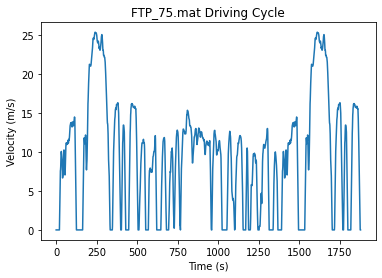

              V_z         T_z         D_z       v_ave         v_max  v_min  \
count  231.000000  231.000000  231.000000  231.000000  2.310000e+02  231.0   
mean     9.409572  116.000000    0.000000    9.409572  1.944444e+01    0.0   
std      7.619817   66.828138    0.378112    0.000000  3.560429e-15    0.0   
min      0.000000    1.000000   -0.833333    9.409572  1.944444e+01    0.0   
25%      0.000000   58.500000    0.000000    9.409572  1.944444e+01    0.0   
50%     12.152778  116.000000    0.000000    9.409572  1.944444e+01    0.0   
75%     16.666667  173.500000    0.252525    9.409572  1.944444e+01    0.0   
max     19.444444  231.000000    0.771605    9.409572  1.944444e+01    0.0   

       a_ave  
count  231.0  
mean     0.0  
std      0.0  
min      0.0  
25%      0.0  
50%      0.0  
75%      0.0  
max      0.0  
['City_MAN.mat' '11_MODE_4.mat' 'WLTP_EXTRAHIGHecoData.mat' 'CITY_I.mat'
 'EUDC_MAN.mat' 'NEDC_EUDC.mat' 'WLTP_HIGH_OCP.mat' 'EUDC.mat'
 'NEDC_MANecoData.mat' 'NE

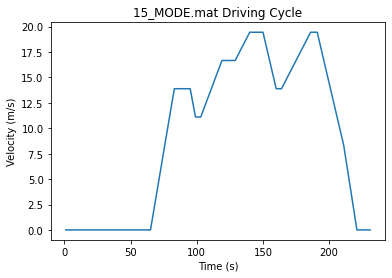

In [57]:
# loading datasets
dc_path = './DrivingCycles/'
dataset_train  = DrivingCyclesDataset(dc_path, idxs_train, idxs_test, train=True)
dataset_test = DrivingCyclesDataset(dc_path, idxs_train, idxs_test, train=False)

# Plot samples from the test set
# Europe NEDC 
sample_data = dataset_train.data[27]
sample_name = dataset_train.names[27]
print(sample_data.describe())
plt.title(sample_name + " Driving Cycle")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.plot(sample_data['T_z'], sample_data['V_z'])
plt.show()

# Europe WLTP 
sample_data = dataset_train.data[38]
sample_name = dataset_train.names[38]
print(sample_data.describe())
plt.title(sample_name + " Driving Cycle")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.plot(sample_data['T_z'], sample_data['V_z'])
plt.show()

# Japan 10 Mode 
sample_data = dataset_train.data[31]
sample_name = dataset_train.names[31]
print(sample_data.describe())
plt.title(sample_name + " Driving Cycle")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.plot(sample_data['T_z'], sample_data['V_z'])
plt.show()

# US FTP_75 
sample_data = dataset_train.data[17]
sample_name = dataset_train.names[17]
print(sample_data.describe())
plt.title(sample_name + " Driving Cycle")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.plot(sample_data['T_z'], sample_data['V_z'])
plt.show()

# Plot 1 sample from the test set
sample_data = dataset_test.data[0]
sample_name = dataset_test.names[0]
print(sample_data.describe())
print(dataset_train.names)
plt.title(sample_name + " Driving Cycle")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.plot(sample_data['T_z'], sample_data['V_z'])
plt.show()

# scaling the datasets 
scaler = MinMaxScaler(feature_range=(0,1))
for df in dataset_train: 
    df['V_z'] = scaler.fit_transform(df[['V_z']])
for df in dataset_test: 
    df['V_z'] = scaler.fit_transform(df[['V_z']])

# create training set and test set 
x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)

# reshaping input to LSTM model 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## Step 3: LSTM
In this section we will try to make a LSTM predictor to predict the future velocity. 

### Step 3.1: Define the model. (15 points)

Design a neural network which consists of a number of convolutional layers and a few fully connected ones at the end.

The exact architecture is up to you but you do NOT need to create something complicated. For example, you could design a LeNet insprired network.

In [71]:
# Network 
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1))) # units depends on create_dataset function
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

### Step 3.2: Define the training parameters. (10 points)

- Loss function
- Optimizer
- Learning Rate
- Number of iterations
- Batch Size
- Other relevant hyperparameters

In [73]:
# compile the model 
model.compile(loss='mse', optimizer='adam')

### Step 3.3: Train the model. (15 points)

Complete the training loop.

In [74]:
model.fit(x_train, y_train, epochs=10, batch_size=32)
model.save('speed_prediction.h5')

# load the model 
model = load_model('speed_prediction.h5') 

Epoch 1/10
2792/2792 [==============================] - 693s 245ms/step - loss: 2.5664 - root_mean_squared_error: 1.6020
Epoch 2/10
2792/2792 [==============================] - 691s 247ms/step - loss: 0.6889 - root_mean_squared_error: 0.8300
Epoch 3/10
2792/2792 [==============================] - 708s 254ms/step - loss: 0.6300 - root_mean_squared_error: 0.7938
Epoch 4/10
2792/2792 [==============================] - 828s 297ms/step - loss: 0.6051 - root_mean_squared_error: 0.7779
Epoch 5/10
2792/2792 [==============================] - 715s 256ms/step - loss: 0.5508 - root_mean_squared_error: 0.7422
Epoch 6/10
2792/2792 [==============================] - 799s 286ms/step - loss: 0.5176 - root_mean_squared_error: 0.7194
Epoch 7/10
2792/2792 [==============================] - 881s 316ms/step - loss: 0.5114 - root_mean_squared_error: 0.7151
Epoch 8/10
2792/2792 [==============================] - 753s 270ms/step - loss: 0.4738 - root_mean_squared_error: 0.6883
Epoch 9/10
2792/2792 [==========

### Step 3.4: Deploy the trained model onto the test set. 

In [75]:
predictions = model.predict(x_test)
# predictions = scaler.inverse_transform(predictions)
# y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

### Step 3.5: Evaluate the performance of the model and visualize the confusion matrix. (5 points)

You can use sklearns related function.

Text(0, 0.5, 'Time (s)')

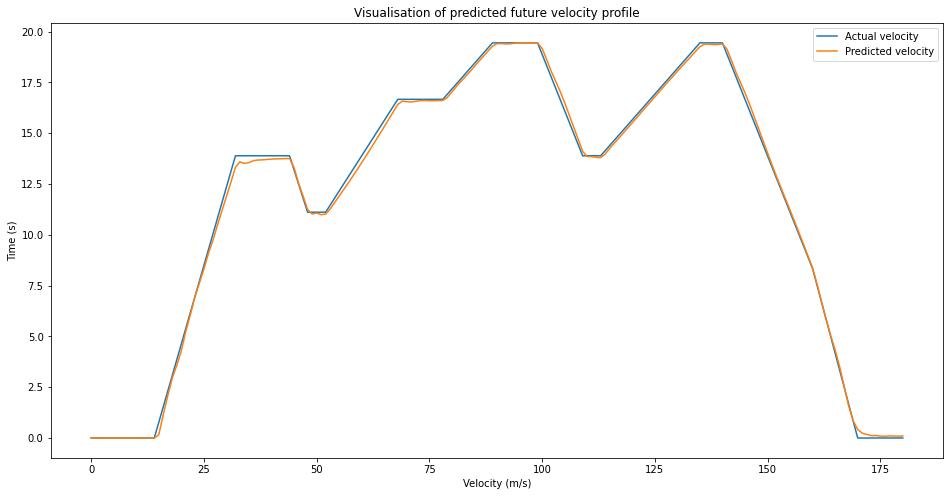

In [81]:
fig, ax = plt.subplots(figsize=(16,8))
# ax.set_facecolor('#000041')
ax.plot(y_test, label='Actual velocity')
plt.plot(predictions, label='Predicted velocity')
plt.legend()
plt.title('Visualisation of predicted future velocity profile')
plt.xlabel("Velocity (m/s)")
plt.ylabel("Time (s)")